<a href="https://colab.research.google.com/github/kimdohyoung96/Adversarial-Distortion-Learning/blob/master/231113_ADL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install tensorflow-addons

In [34]:
!pip install import_ipynb
!pip install keras==2.2.2

from typing import Callable, Tuple, Union, Iterable, List, Optional, Dict
import os
import json
import itertools
import shutil
import pathlib as P
from PIL import Image
from tensorflow import keras
from tensorflow_addons.image import utils as img_utils
from tensorflow.python.keras.utils import conv_utils
import tensorflow.keras as keras

adl_folder='ADL'

if os.path.isdir(adl_folder):
    shutil.rmtree(adl_folder)
%rm -rf adl_folder

# Clone the repo
!git clone https://github.com/mogvision/ADL.git

%cd ADL
Root = get_ipython().magic('pwd')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.3/299.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.14.0 requires keras<2.15,>=2.14.0, but you have keras 2.2.2 which is incompatible.


Cloning into 'ADL'...
remote: Enumerating objects: 708, done.
remote: Counting objects: 100% (469/469), done.
remote: Compressing objects: 100% (238/238), done.
remote: Total 708 (delta 296), reused 351 (delta 195), pack-reused 239
Receiving objects: 100% (708/708), 43.77 MiB | 37.29 MiB/s, done.
Resolving deltas: 100% (345/345), done.
/content/ADL/ADL/ADL/ADL/ADL/ADL


In [35]:
import glob
from google.colab import files

results_dir = f'{Root}/results'

if not os.path.exists(results_dir):
    os.mkdir(results_dir)
    os.mkdir(f'{results_dir}/folder1')

# upload images
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(results_dir, 'folder1', filename)
  print(f'move {filename} to {results_dir}')
  shutil.move(filename, dst_path)

# adding distortion to images
config = {
        "H": -1,
        "W": -1,
        "num_channels":3,
        "batch_size_per_gpu": 1,
        "adding_noise": True,
        "adding_blur": False, # True if the model is uploaded
        "adding_compression": False, # True if the model is uploaded
        "test_stdVec": [5, 10., 20.], # noise level (sigma/255)
        "test_blurVec":  [0],
        "test_compresVec": [1.],
        "localhost":None,
        "img_types": ["png", "jpg", "jpeg", "bmp"],
        "num_sel_imgs":-1
    }

config['test_stdVec'] = [val*1. for val in config['test_stdVec']]
%run '/content/ADL/TensorFlow/util/DataLoader_colab.py'

Saving gt-test015c.png to gt-test015c.png
move gt-test015c.png to /content/ADL/ADL/ADL/ADL/ADL/ADL/results


In [36]:
import tensorflow as tf
model = tf.keras.models.load_model(f'{Root}/TensorFlow/pretrained_models/RGB_model_WGN/checkpoint-36', compile=False)
print('Currently, just an RGB model (trained on imagenet) for WGN is uploaded...')

Currently, just an RGB model (trained on imagenet) for WGN is uploaded...


In [37]:
import numpy as np
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
test_DSs = DataLoader(config = config, test_ds_dir = results_dir)()

gt_ds, inp_ds, adl_results, noise_level = [], [], [], []

for ds_name, DSs in test_DSs.items():
            print(f"dataset: {ds_name}..." )

            for distortion_name, DS in DSs.items():
                print(f"\tdistortion type: {distortion_name}...")
                sigma = int(float(distortion_name.split('_wgn_')[-1]))
                noise_level.append(sigma)

                for inp, gt, img_name in DS.batch(1):
                    y_hat, _, _ = model.predict(inp)

                    gt_ds.append(np.squeeze(gt.numpy()).astype(np.float32))
                    inp_ds.append(np.squeeze(inp.numpy()).astype(np.float32))
                    adl_results.append(np.squeeze(tf.identity(y_hat).numpy()).astype(np.float32))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

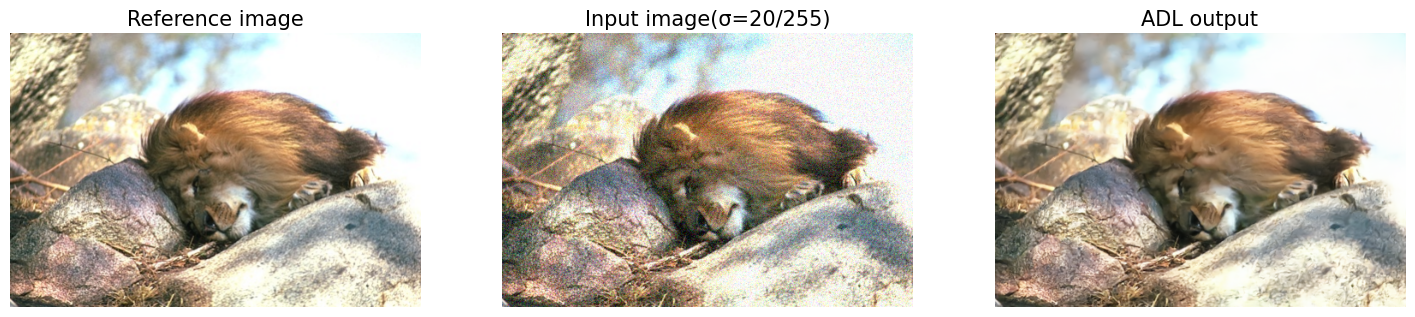

In [38]:
import cv2
import matplotlib.pyplot as plt

def display(im_gt, im_inp, im_adl, sigma, img_id):
    num_figs = 3
    fontsize= 15

    fig = plt.figure(figsize=(num_figs*6, 8))

    ax1 = fig.add_subplot(1, num_figs, 1)
    plt.title('Reference image', fontsize=fontsize)
    ax1.axis('off')
    ax1.imshow(im_gt)

    ax2 = fig.add_subplot(1, num_figs, 2)
    plt.title( f'Input image(\N{greek small letter sigma}={sigma}/255)', fontsize=fontsize)
    ax2.axis('off')
    ax2.imshow(np.clip(im_inp, 0, 1) )

    ax3 = fig.add_subplot(1, num_figs, 3)
    plt.title('ADL output', fontsize=fontsize)
    ax3.axis('off')
    ax3.imshow(im_adl)

img_id = -1
display(gt_ds[img_id],
        inp_ds[img_id],
        adl_results[img_id],
        noise_level[img_id],
        img_id)